# Keyword extraction, treniding words detection

In this notebook, we will be extracting keywords from 200k quotes of 2020, detecting the trending words, generating word cloud based on freqencies, histograms over time, as well as trying to perfom some word embedings.

In [48]:
!pip install tld
!pip install pyarrow
!pip install Wikidata
!pip install keybert[flair]

In [49]:
import math
from matplotlib import animation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
from wordcloud import WordCloud, STOPWORDS
import numpy as np 
import pandas as pd
import json
import os
import bz2
import itertools 

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Keyword extraction

In [ ]:
# Import KeyBERT for keyword extraction
from keybert import KeyBERT
kw_model = KeyBERT()

  0%|          | 0.00/83.5M [00:00<?, ?B/s]

In [ ]:
# Extract up to 3 keywords for each quote in 2020

year = 2020
path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2' 
path_to_out = f'/content/drive/MyDrive/Quotebank_limunADA/keywords-{year}.json.bz2'

finished = 0

try:
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for instance in s_file:
        instance = json.loads(instance)
        
        keywords = kw_model.extract_keywords(instance['quotation'], keyphrase_ngram_range = (1,1), top_n=3)
        
        keywords_object = {
            'id' : instance['quoteID'],
            'keywords' : keywords,
            'date' : instance['date']
        }

        d_file.write((json.dumps(keywords_object)+'\n').encode('utf-8'))
        finished+=1
        #if finished % 1000 == 0:
        #  print('Finished', finished)

except KeyboardInterrupt:
  print('Written into file:', finished)

## Word cloud

In [39]:
file_path = '/content/drive/MyDrive/Quotebank_limunADA/keywords-2020.json.bz2'
counts = {}

# Count frequency of each keyword
with bz2.open(file_path, "rt") as file_handle:
    for keyword_row in file_handle:
      row_object = json.loads(keyword_row)
      for keyword in row_object['keywords']:
        keyword = keyword[0]
        if keyword in counts:
          counts[keyword]+=1
        else:
          counts[keyword]=1

In [45]:
# Extract 30 words of the highest frequency
top_30_words = dict(sorted(counts.items(), key=lambda item: item[1])[-30:])

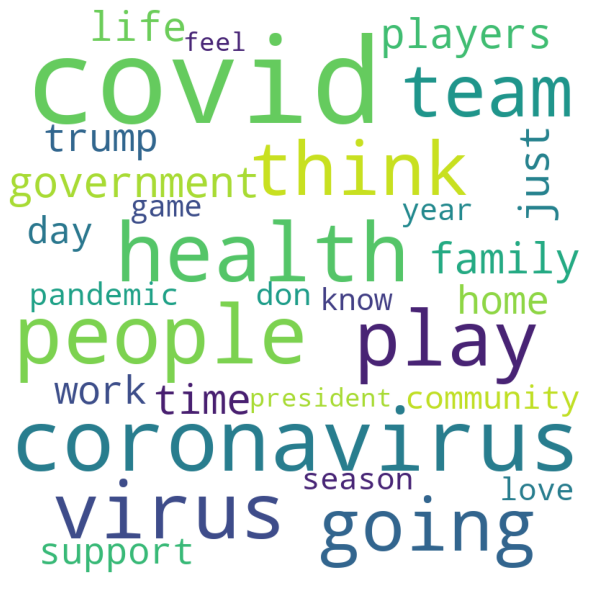

In [50]:
# Plot word cloud of the 30 most frequent keywords
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate_from_frequencies(top_30_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

As expected, some of the most frequent keywords at the beginning of 2020 were covid, coronavirus, health, pandemic, support etc.

## Animated histograms

In [2]:
file_path = '/content/drive/MyDrive/Quotebank_limunADA/keywords-2020.json.bz2'
TOTAL_KEYWORDS = 3
# NEED TO CREATE "figs" folder and "movies" folder

# Months (start indexing from 1)
MONTHS = ['', 'January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

# Days per Month (start indexing from 1)
days_per_month = [None, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Keep track of top most frequent Keywords
KEEP_TOP_MOST_FREQUENT_WORDS = 5

#KEEP_MONTHS_UNTIL = MONTHS.index("May") #it will not include month KEEP_MONTHS_UNTIL
time_interval = 5 # time_interval to average days

#Last day of given dataset
last_day = 18
last_month = 4
last_year = 2020

In [26]:
def get_datetime(dict_):
  # Takes dictionary dict_ that has one key called "date", and extracts date and time
  # The key 'date' in format of "yyyy-mm-dd hh:mm:ss" string (e.g. "2020-02-10 23:45:54")
  date, time = dict_['date'][:10], dict_['date'][11:]
  years, months, days = int(date[:4]), int(date[5:7]), int(date[8:])
  hours, minutes, seconds = int(time[:2]), int(time[3:5]), int(time[6:8])
  return (seconds, minutes, hours, days, months, years)

def load_keywords(file_path, TOTAL_KEYWORDS):
  # From file on the file_path
  # id :: string, date :: string, seconds :: int, ..., years :: int, keyword :: string, keyvalue :: float, keyword_number :: int
  table ={}
  with bz2.open(file_path, "rt") as file_handle:
    for i, line in enumerate(file_handle):
        string_quote = json.loads(line)
        table[i] = string_quote
        table[i]["seconds"], table[i]["minutes"], \
        table[i]["hours"], table[i]["days"], \
        table[i]["months"], table[i]["years"] = get_datetime(table[i])
        
        for keyword_idx in range(len(table[i]['keywords'])):
          # if the number of keywords is less than TOTAL_KEYWORDS it will fill out values
          # with Not-a-Number (NaN) later in pandas DataFrame
          table[i]["keyword"+str(keyword_idx)] = table[i]['keywords'][keyword_idx][0] # save keywords
          table[i]["keyvalue"+str(keyword_idx)] = table[i]['keywords'][keyword_idx][1]
        
        table[i]["keyword_number"] = len(table[i]['keywords'])
        if table[i]["id"] == "2020-02-27-024810": # currently hard-coded to get rid of EOF
          break
  table_df = pd.DataFrame.from_dict(table, orient = "index")
  table_df.drop(["keywords"], axis = 1, inplace = True)
  for j in range(TOTAL_KEYWORDS):
    table_df["keyword" + str(j)].fillna("OTHER", inplace = True)
  return table_df


def get_aggregated_keyword_frequencies(table_df, time_interval):
  # Get the keyword frequencies from table_df given the time_interval 
  # in days to aggregate the data on
  d = {}
  for month in range(1,12 + 1):
    d[MONTHS[month]] = {}
    for day in range(1,days_per_month[month] + 1, time_interval):
      keywords = {}
      for agragated_days in range(day, day+time_interval, 1):
        for keyword_idx in range(TOTAL_KEYWORDS):
          all_words = table_df[(table_df["months"] == month) & \
                               (table_df["days"] == agragated_days)]["keyword" + str(keyword_idx)].values
          for word in all_words:  
            if word == 'OTHER':
              continue
            if word in keywords:
              keywords[word] += 1
            else:
              keywords[word] = 1

      # sorting decreasingly by importance a dictonary of keywords
      keywords = {k: v for k, v in sorted(keywords.items(), key=lambda item: item[1], reverse=True)}
      d[MONTHS[month]]["day_interval_" + str("0" if day <= 9 else "") + str(day) + \
                       "_"+str("0" if (day+time_interval-1) <= 9 else "") + str(day+time_interval-1)] = keywords
    if last_month == month and last_day <= day + time_interval:
      break

  table_df_aggregated = pd.DataFrame.from_dict(d)
  return table_df_aggregated

def get_keywords_histograms_over_time(table_df, last_day, last_month, time_interval):
  # Create a set of histograms with keywords over the desired time interval

  images = {}
  for month in range(1,12 + 1):
    for day in range(1,days_per_month[month] - time_interval + 1, time_interval):

      if last_month == month and last_day <= day + time_interval:
        break
      d = table_df.loc["day_interval_" + str("0" if day <= 9 else "") + str(day)+ \
                       "_"+str("0" if (day+time_interval-1) <= 9 else "") \
                       + str(day+time_interval-1)][MONTHS[month]]

      dd = {}
      for i, k in enumerate(d):
        if i == KEEP_TOP_MOST_FREQUENT_WORDS:
          break
        if dict == type(d):
          # d is not nan
          dd[k] = d[k]
      
      if not bool(dd):
        # dictionary is empty
        continue
      
      im_name = "day_interval_" + str("0" if day <= 9 else "") + \
      str(day)+"_"+str("0" if (day+time_interval-1) <= 9 else "") + \
      str(day+time_interval-1)+"_year_2020"

      plt.bar(dd.keys(), dd.values(), width = 0.5, color='g')
      plt.title(f"{('0' if day <= 9 else '') + str(day)}. - {str('0' if (day+time_interval-1) <= 9 else '') + str(day+time_interval-1)}. {MONTHS[month]}")
      plt.savefig(f"figs/{im_name}.png")

      images[(day, month)] = plt.imread(f"figs/{im_name}.png")
      plt.close()

    if last_month == month and last_day <= day + time_interval:
      break

  return images

def make_movie_from_plots(images, last_day, last_month, movie_name, time_interval):
  # Creates a video from the set of images on the desired time interval

  frames = [] # for storing the generated images
  fig = plt.figure()

  for month in range(1,12 + 1):
    for day in range(1,days_per_month[month] - time_interval + 1, time_interval):

      if last_month == month and last_day <= day + time_interval:
        break

      # Add frame to video
      frames.append([plt.imshow(images[(day, month)], cmap=cm.Greys_r,animated=True)])

    if last_month == month and last_day <= day + time_interval:
      break
  ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True,
                                  repeat_delay=50)
  ani.save(movie_name)
  plt.close()


In [27]:
table_df = load_keywords(file_path, TOTAL_KEYWORDS)

In [28]:
# Create video for most frequent keywords on the 7 day interval
time_interval = 7
table_df_2 = get_aggregated_keyword_frequencies(table_df, time_interval)
im = get_keywords_histograms_over_time(table_df_2, last_day, last_month, time_interval = time_interval)
make_movie_from_plots(im, last_day, last_month, '2020_7_day.mp4', time_interval = time_interval)

In [2]:
# Demonstrational video
from IPython.display import Video
Video("2020_7_day.mp4")

It is interesting note Iran was one of the trending words which is in correlation with the Trump ordering the killing of top Iranian military commander Qassem Soleimani. Additionally, we can notice trending words coronavirus, covid, health, virus and community in the beginning of March (when the COVID-19 pandemic reached Europe and USA).